# Programming Assignment 1: Learning Distributed Word Representations

**Due Date**: October 4, 2023 by 2pm


**Submission:**
You must submit two files:
1. [ ] A PDF file containing your writeup, which will be the PDF export of this notebook (i.e., by printing this notebook webpage as PDF). Note that after you generate the PDF file of the Notebook, you will need to **concatenate it with the PDF file of your solutions to written problems**. Make sure that the relevant outputs (e.g. `print_gradients()` outputs, plots, etc.) are included and clearly visible. The **concatenated PDF file** needs to be submitted to **GradeScope**.
2. [ ] The `hw1_code_<YOUR_UNI>.ipynb` iPython Notebook, where `<YOUR_UNI>` is your uni. This file needs to be submitted to the **CourseWorks assignment page**.

The programming assignments are individual work.  

You should attempt all questions for this assignment. Most of them can be answered at least partially even if you were unable to finish earlier questions. If you think your computational results are incorrect, please say so; that may help you get partial credit.
   
    
# Introduction
In this assignment we will learn about word embeddings and make neural networks learn about words.
We could try to match statistics about the words, or we could train a network that takes a sequence of words as input and learns to predict the word that comes next.
        
This assignment will ask you to implement a linear embedding and then the backpropagation computations for a neural language model and then run some experiments to analyze the learned representation.
The amount of code you have to write is very short but each line will require you to think very carefully.
You will need to derive the updates mathematically, and then implement them using matrix and vector operations in NumPy.

# Starter code and data

First, perform the required imports for your code:


In [1]:
from kret_studies import *
from kret_studies.notebook import *
from kret_studies.complex import *

Loaded environment variables from /Users/Akseldkw/Desktop/Columbia/COMS4776/.env.


In [2]:
import collections
import pickle
import numpy as np
import os
from tqdm import tqdm
import pylab
from six.moves.urllib.request import urlretrieve
import tarfile
import sys

TINY = 1e-30
EPS = 1e-4
nax = np.newaxis

If you're using colaboratory, this following script creates a folder - here we used 'A1' - in order to download and store the data. If you're not using colaboratory, then set the path to wherever you want the contents to be stored at locally.

You can also manually download and unzip the data from [http://www.cs.columbia.edu/~zemel/Class/Nndl/files/a1_data.tar.gz] and put them in the same folder as where you store this notebook.

Feel free to use a different way to access the files *data.pk* , *partially_trained.pk*, and *raw_sentences.txt*.

The file *raw_sentences.txt* contains the sentences that we will be using for this assignment.
These sentences are fairly simple ones and cover a vocabulary of only 250 words (+ 1 special `[MASK]` token word).





In [3]:
######################################################################
# Setup working directory
######################################################################
# Change this to a local path if running locally
# %mkdir -p /content/A1/
# %cd /content/A1

######################################################################
# Helper functions for loading data
######################################################################
# adapted from
# https://github.com/fchollet/keras/blob/master/keras/datasets/cifar10.py


from urllib.error import URLError, HTTPError


def get_file(
    fname, origin, untar=False, extract=False, archive_format="auto", cache_dir="data"
):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + ".tar.gz"
    else:
        fpath = os.path.join(datadir, fname)

    print("File path: %s" % fpath)
    if not os.path.exists(fpath):
        print("Downloading data from", origin)

        error_msg = "URL fetch failure on {}: {} -- {}"
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print("Extracting file.")
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath

In [4]:
# Download the dataset and partially pre-trained model
drive_location = "/Users/Akseldkw/coding/Columbia/COMS4776-Data/data"
get_file(
    fname="a1_data",
    origin="http://www.cs.columbia.edu/~zemel/Class/Nndl/files/a1_data.tar.gz",
    untar=True,
    cache_dir=drive_location,
)
PARTIALLY_TRAINED_MODEL = drive_location + "/" + "partially_trained.pk"
data_location = drive_location + "/" + "data.pk"

File path: /Users/Akseldkw/coding/Columbia/COMS4776-Data/data/a1_data.tar.gz
Extracting file.


/var/folders/dj/k5kk5wk90vvcnb_wphpw490r0000gn/T/ipykernel_40096/1658915410.py:52: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  archive.extractall(datadir)


We have already extracted the 4-grams from this dataset and divided them into training, validation, and test sets.
To inspect this data, run the following:

In [5]:
data = pickle.load(open(data_location, "rb"))
print(data["vocab"][0])  # First word in vocab is [MASK]
print(data["vocab"][1])
print(len(data["vocab"]))  # Number of words in vocab
print(data["vocab"])  # All the words in vocab
print(data["train_inputs"][:10])  # 10 example training instances

[MASK]
all
251
['[MASK]', np.str_('all'), np.str_('set'), np.str_('just'), np.str_('show'), np.str_('being'), np.str_('money'), np.str_('over'), np.str_('both'), np.str_('years'), np.str_('four'), np.str_('through'), np.str_('during'), np.str_('go'), np.str_('still'), np.str_('children'), np.str_('before'), np.str_('police'), np.str_('office'), np.str_('million'), np.str_('also'), np.str_('less'), np.str_('had'), np.str_(','), np.str_('including'), np.str_('should'), np.str_('to'), np.str_('only'), np.str_('going'), np.str_('under'), np.str_('has'), np.str_('might'), np.str_('do'), np.str_('them'), np.str_('good'), np.str_('around'), np.str_('get'), np.str_('very'), np.str_('big'), np.str_('dr.'), np.str_('game'), np.str_('every'), np.str_('know'), np.str_('they'), np.str_('not'), np.str_('world'), np.str_('now'), np.str_('him'), np.str_('school'), np.str_('several'), np.str_('like'), np.str_('did'), np.str_('university'), np.str_('companies'), np.str_('these'), np.str_('she'), np.str_

Now `data` is a Python dict which contains the vocabulary, as well as the inputs and targets for all three splits of the data. `data['vocab']` is a list of the 251 words in the dictionary; `data['vocab'][0]` is the word with index 0, and so on. `data['train_inputs']` is a 372,500 x 4 matrix where each row gives the indices of the 4 consecutive context words for one of the 372,500 training cases.
The validation and test sets are handled analogously.

Even though you only have to modify two specific locations in the code, you may want to read through this code before starting the assignment.

# Part 1: GLoVE Word Representations (16pts)

In this part of the assignment, you will implement a simplified version of the GLoVE embedding (please see the handout for detailed description of the algorithm) with the loss defined as

$$L(\{\mathbf{w}_i,\tilde{\mathbf{w}}_i,b_i, \tilde{b}_i\}_{i=1}^V) = \sum_{i=1}^V \sum_{j=1}^V \left(\mathbf{w}_i^\top\tilde{\mathbf{w}}_j + b_i + \tilde{b}_j - \log X_{ij}\right)^2$$

Note that each word is represented by two $d$-dimensional embedding vectors $\mathbf{w}_i, \tilde{\mathbf{w}}_i$ and two scalar biases $b_i, \tilde{b}_i$.



Answer the following questions:

## 1.1.  GLoVE Parameter Count \[1pt\]
Given the vocabulary size $V$ and embedding dimensionality $d$, how many parameters does the GLoVE model have?  Note that each word in the vocabulary is associated with 2 embedding vectors and 2 biases.

1.1 **Answer**: Parameters = $2Vd + 2V = 2V(d+1)$

## 1.2. Expression for gradient $\frac{\partial L}{\partial \mathbf{w}_i}$ and $\frac{\partial L}{\partial \mathbf{b}_i}$ \[6pts\]

Write the expression for $\frac{\partial L}{\partial \mathbf{w}_i}$ and $\frac{\partial L}{\partial \mathbf{b}_i}$, the gradient of the loss function $L$ with respect to parameter vector $\mathbf{w}_i$ and $\mathbf{b}_i$. The gradient should be a function of $\mathbf{w}, \tilde{\mathbf{w}}, b, \tilde{b}, X$ with appropriate subscripts (if any).

1.2 **Answer**:

$L(\{\mathbf{w}_i,\tilde{\mathbf{w}}_i,b_i, \tilde{b}_i\}_{i=1}^V) = \sum_{i=1}^V \sum_{j=1}^V \left(\mathbf{w}_i^\top\tilde{\mathbf{w}}_j + b_i + \tilde{b}_j - \log X_{ij}\right)^2$


$\tfrac{\partial L}{\partial \mathbf{w}_i} = \sum_{j=1}^V 2\left(\mathbf{w}_i^\top\tilde{\mathbf{w}}_j + b_i + \tilde{b}_j - \log X_{ij}\right) \tilde{\mathbf{w}}_j$


$\tfrac{\partial L}{\partial b_i} = \sum_{j=1}^V 2\left(\mathbf{w}_i^\top\tilde{\mathbf{w}}_j + b_i + \tilde{b}_j - \log X_{ij}\right)$


## 1.3.  Implement the gradient update of GLoVE. \[6pts\]

**See** `YOUR CODE HERE` **Comment below for where to complete the code**


We have provided a few functions for training the embedding:

*   `calculate_log_co_occurence` computes the log co-occurrence matrix of a given corpus
*   `train_GLoVE` runs momentum gradient descent to optimize the embedding
*   `loss_GLoVE`:
  * INPUT - $V\times d$ matrix `W` (collection of $V$ embedding vectors, each $d$-dimensional); $V\times d$ matrix `W_tilde`; $V\times 1$ vector `b` (collection of $V$ bias terms); $V\times 1$ vector `b_tilde`; $V \times V$ log co-occurrence matrix.
  * OUTPUT - loss of the GLoVE objective
*   `grad_GLoVE`: **TO BE IMPLEMENTED.**
  * INPUT:
      * $V\times d$ matrix `W` (collection of $V$ embedding vectors, each $d$-dimensional), embedding for first word;
      * $V\times d$ matrix `W_tilde`, embedding for second word;
      * $V\times 1$ vector `b` (collection of $V$ bias terms);
      * $V\times 1$ vector `b_tilde`, bias for second word;
      * $V \times V$ log co-occurrence matrix.
  * OUTPUT:
      * $V\times d$ matrix `grad_W` containing the gradient of the loss function w.r.t. `W`;
      * $V\times d$ matrix `grad_W_tilde` containing the gradient of the loss function w.r.t. `W_tilde`;
      * $V\times 1$ vector `grad_b` which is the gradient of the loss function w.r.t. `b`.
      * $V\times 1$ vector `grad_b_tilde` which is the gradient of the loss function w.r.t. `b_tilde`.

Run the code to compute the co-occurence matrix.
Make sure to add a 1 to the occurences, so there are no 0's in the matrix when we take the elementwise log of the matrix.


In [6]:
data["train_inputs"].shape

(372500, 4)

In [7]:
data["train_inputs"][0]

array([ 28,  26,  90, 144], dtype=int32)

In [8]:
vocab_size = len(data["vocab"])  # Number of vocabs


def calculate_log_co_occurence(word_data: np.ndarray, symmetric: bool = False):
    "Compute the log-co-occurence matrix for our data."
    log_co_occurence = np.zeros((vocab_size, vocab_size))
    for input in word_data:
        # Note: the co-occurence matrix may not be symmetric
        log_co_occurence[input[0], input[1]] += 1
        log_co_occurence[input[1], input[2]] += 1
        log_co_occurence[input[2], input[3]] += 1
        # If we want symmetric co-occurence can also increment for these.
        if symmetric:
            log_co_occurence[input[1], input[0]] += 1
            log_co_occurence[input[2], input[1]] += 1
            log_co_occurence[input[3], input[2]] += 1
    delta_smoothing = 0.5  # A hyperparameter.  You can play with this if you want.
    log_co_occurence += delta_smoothing  # Add delta so log doesn't break on 0's.
    log_co_occurence = np.log(log_co_occurence)
    return log_co_occurence

In [9]:
vocab_size

251

In [10]:
asym_log_co_occurence_train = calculate_log_co_occurence(
    data["train_inputs"], symmetric=False
)
asym_log_co_occurence_valid = calculate_log_co_occurence(
    data["valid_inputs"], symmetric=False
)

* [ ] **TO BE IMPLEMENTED**: Calculate the gradient of the loss function w.r.t. the parameters $W$, $\tilde{W}$, $\mathbf{b}$, and $\mathbf{b}$. You should vectorize the computation, i.e. not loop over every word. The reading of the matrix cookbook from https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf might be useful.

$L(\{\mathbf{w}_i,\tilde{\mathbf{w}}_i,b_i, \tilde{b}_i\}_{i=1}^V) = \sum_{i=1}^V \sum_{j=1}^V \left(\mathbf{w}_i^\top\tilde{\mathbf{w}}_j + b_i + \tilde{b}_j - \log X_{ij}\right)^2$


$\tfrac{\partial L}{\partial \mathbf{w}_i} = \sum_{j=1}^V 2\left(\mathbf{w}_i^\top\tilde{\mathbf{w}}_j + b_i + \tilde{b}_j - \log X_{ij}\right) \tilde{\mathbf{w}}_j$


$\tfrac{\partial L}{\partial b_i} = \sum_{j=1}^V 2\left(\mathbf{w}_i^\top\tilde{\mathbf{w}}_j + b_i + \tilde{b}_j - \log X_{ij}\right)$


In [11]:
def loss_GLoVE(
    W: np.ndarray,
    W_tilde: np.ndarray | None,
    b: np.ndarray,
    b_tilde: np.ndarray | None,
    log_co_occurence: np.ndarray,
):
    "Compute the GLoVE loss."
    n, _ = log_co_occurence.shape
    if W_tilde is None and b_tilde is None:
        return np.sum(
            (W @ W.T + b @ np.ones([1, n]) + np.ones([n, 1]) @ b.T - log_co_occurence)
            ** 2
        )
    else:
        W_tilde = t.cast(np.ndarray, W_tilde)
        b_tilde = t.cast(np.ndarray, b_tilde)
        return np.sum(
            (
                W @ W_tilde.T
                + b @ np.ones([1, n])
                + np.ones([n, 1]) @ b_tilde.T
                - log_co_occurence
            )
            ** 2
        )


def grad_GLoVE(
    W: np.ndarray,
    W_tilde: np.ndarray | None,
    b: np.ndarray,
    b_tilde: np.ndarray | None,
    log_co_occurence: np.ndarray,
):
    "Return the gradient of GLoVE objective w.r.t W and b."
    "INPUT: W - Vxd; W_tilde - Vxd; b - Vx1; b_tilde - Vx1; log_co_occurence: VxV"
    "OUTPUT: grad_W - Vxd; grad_W_tilde - Vxd, grad_b - Vx1, grad_b_tilde - Vx1"
    n, _ = log_co_occurence.shape

    if not W_tilde is None and not b_tilde is None:
        loss = (
            W @ W_tilde.T
            + b @ np.ones([1, n])
            + np.ones([n, 1]) @ b_tilde.T
            - 0.5 * (log_co_occurence + log_co_occurence.T)
        )
        coef = 2
        grad_W = coef * (W_tilde.T @ loss).T
        grad_W_tilde = coef * (W.T @ loss).T
        grad_b = coef * (np.ones([1, n]) @ loss).T
        grad_b_tilde = coef * (np.ones([n, 1]).T @ loss).T
    else:
        loss = (
            W @ W.T
            + b @ np.ones([1, n])
            + np.ones([n, 1]) @ b.T
            - 0.5 * (log_co_occurence + log_co_occurence.T)
        )
        grad_W = 4 * (W.T @ loss).T
        grad_W_tilde = None
        grad_b = 4 * (np.ones([1, n]) @ loss).T
        grad_b_tilde = None

    return grad_W, grad_W_tilde, grad_b, grad_b_tilde


def train_GLoVE(
    W: np.ndarray,
    W_tilde: np.ndarray | None,
    b: np.ndarray,
    b_tilde: np.ndarray | None,
    log_co_occurence_train: np.ndarray,
    log_co_occurence_valid: np.ndarray,
    n_epochs: int,
    do_print: bool = False,
):
    "Traing W and b according to GLoVE objective."
    n, _ = log_co_occurence_train.shape
    learning_rate = 0.05 / n  # A hyperparameter.  You can play with this if you want.
    for epoch in range(n_epochs):
        grad_W, grad_W_tilde, grad_b, grad_b_tilde = grad_GLoVE(
            W, W_tilde, b, b_tilde, log_co_occurence_train
        )
        W = W - learning_rate * grad_W
        b = b - learning_rate * grad_b
        if not grad_W_tilde is None and not grad_b_tilde is None:
            W_tilde = W_tilde - learning_rate * grad_W_tilde
            b_tilde = b_tilde - learning_rate * grad_b_tilde
        train_loss, valid_loss = loss_GLoVE(
            W, W_tilde, b, b_tilde, log_co_occurence_train
        ), loss_GLoVE(W, W_tilde, b, b_tilde, log_co_occurence_valid)
        if do_print:
            print(
                f"Train Loss: {train_loss}, valid loss: {valid_loss}, grad_norm: {np.sum(grad_W**2)}"
            )
    return W, W_tilde, b, b_tilde, train_loss, valid_loss

Train the GLoVE model for a range of embedding dimensions

In [100]:
"""NOTE only rerun cell to reset cached values"""

Asym_W_final_2d, Asym_b_final_2d = None, None
Asym_W_tilde_final_2d, Asym_b_tilde_final_2d = None, None
W_final_2d, b_final_2d = None, None

model_vals: dict[tuple[int, str, str], float] = {}

In [101]:
np.random.seed(1)
n_epochs = 500  # A hyperparameter.  You can play with this if you want.
embedding_dims = np.array(
    [1, 2, 5, 8, 10, 32, 64, 128, 256, 512, 1024, 2048, 4096]
)  # Play with this
# embedding_dims = np.array([1, 2, 10, 128, 256, 1024, 4096])  # Play with this
# Store the final losses for graphing

In [102]:
# If you want to see diagnostic information during training


def train_GloVE(
    embedding_dims: np.ndarray, do_print: bool = False, recompute: bool = False
):
    for embedding_dim in tqdm(embedding_dims):
        if not recompute and embedding_dim in [key[0] for key in model_vals.keys()]:
            # don't re-train if we've already trained this embedding size
            print(f"Skipping embedding dim {embedding_dim} since already trained")
            continue
        else:
            print(f"Training embedding dim {embedding_dim}")
        init_variance = 0.1  # A hyperparameter.  You can play with this if you want.
        W = init_variance * np.random.normal(size=(vocab_size, embedding_dim))
        W_tilde = init_variance * np.random.normal(size=(vocab_size, embedding_dim))
        b = init_variance * np.random.normal(size=(vocab_size, 1))
        b_tilde = init_variance * np.random.normal(size=(vocab_size, 1))
        if do_print:
            print(f"Training for embedding dimension: {embedding_dim}")

        # Train Asym model on Asym Co-Oc matrix
        (
            Asym_W_final,
            Asym_W_tilde_final,
            Asym_b_final,
            Asym_b_tilde_final,
            train_loss,
            valid_loss,
        ) = train_GLoVE(
            W,
            W_tilde,
            b,
            b_tilde,
            asym_log_co_occurence_train,
            asym_log_co_occurence_valid,
            n_epochs,
            do_print=do_print,
        )
        if embedding_dim == 2:
            # Save a parameter copy if we are training 2d embedding for visualization later
            global Asym_W_final_2d, Asym_b_final_2d, Asym_W_tilde_final_2d, Asym_b_tilde_final_2d
            Asym_W_final_2d = Asym_W_final
            Asym_W_tilde_final_2d = Asym_W_tilde_final
            Asym_b_final_2d = Asym_b_final
            Asym_b_tilde_final_2d = Asym_b_tilde_final
        model_vals[(embedding_dim, "Asym", "train")] = train_loss
        model_vals[(embedding_dim, "Asym", "val")] = valid_loss
        # asymModel_asymCoOc_final_train_losses += [train_loss]
        # asymModel_asymCoOc_final_val_losses += [valid_loss]
        if do_print:
            print(f"Final validation loss: {valid_loss}")

        # Train Sym model on Asym Co-Oc matrix
        W_final, W_tilde_final, b_final, b_tilde_final, train_loss, valid_loss = (
            train_GLoVE(
                W,
                None,
                b,
                None,
                asym_log_co_occurence_train,
                asym_log_co_occurence_valid,
                n_epochs,
                do_print=do_print,
            )
        )
        if embedding_dim == 2:
            # Save a parameter copy if we are training 2d embedding for visualization later
            global W_final_2d, b_final_2d
            W_final_2d = W_final
            b_final_2d = b_final
        model_vals[(embedding_dim, "Sym", "train")] = train_loss
        model_vals[(embedding_dim, "Sym", "val")] = valid_loss
        if do_print:
            print(f"Final validation loss: {valid_loss}")


def model_dict_to_list(
    model_vals: dict[tuple[int, str, str], float],
    sym: t.Literal["Sym", "Asym"],
    train_or_val: t.Literal["train", "val"],
):
    return [
        val
        for key, val in model_vals.items()
        if key[1] == sym and key[2] == train_or_val
    ]


train_GloVE(embedding_dims=embedding_dims, do_print=False, recompute=False)
asymModel_asymCoOc_final_train_losses = model_dict_to_list(model_vals, "Asym", "train")
asymModel_asymCoOc_final_val_losses = model_dict_to_list(model_vals, "Asym", "val")

symModel_asymCoOc_final_train_losses = model_dict_to_list(model_vals, "Sym", "train")
symModel_asymCoOc_final_val_losses = model_dict_to_list(model_vals, "Sym", "val")

  0%|          | 0/13 [00:00<?, ?it/s]

Training embedding dim 1


  8%|▊         | 1/13 [00:00<00:10,  1.14it/s]

Training embedding dim 2


 15%|█▌        | 2/13 [00:01<00:09,  1.21it/s]

Training embedding dim 5


 23%|██▎       | 3/13 [00:02<00:08,  1.20it/s]

Training embedding dim 8


 31%|███       | 4/13 [00:04<00:10,  1.14s/it]

Training embedding dim 10


 38%|███▊      | 5/13 [00:05<00:10,  1.31s/it]

Training embedding dim 32


 46%|████▌     | 6/13 [00:08<00:11,  1.67s/it]

Training embedding dim 64


 54%|█████▍    | 7/13 [00:10<00:10,  1.79s/it]

Training embedding dim 128


 62%|██████▏   | 8/13 [00:12<00:09,  1.96s/it]

Training embedding dim 256


 69%|██████▉   | 9/13 [00:15<00:08,  2.15s/it]

Training embedding dim 512


 77%|███████▋  | 10/13 [00:18<00:08,  2.67s/it]

Training embedding dim 1024


 85%|████████▍ | 11/13 [00:24<00:07,  3.61s/it]

Training embedding dim 2048


 92%|█████████▏| 12/13 [00:34<00:05,  5.46s/it]

Training embedding dim 4096


100%|██████████| 13/13 [00:54<00:00,  4.16s/it]


Plot the training and validation losses against the embedding dimension.

## 1.4. Effect of embedding dimension $d$ \[3pts\]
Train the both the symmetric and asymmetric GLoVe model with varying dimensionality $d$ by running the cell below. Comment on:
1. Which $d$ leads to optimal validation performance for the asymmetric and symmetric models?
2. Why does / doesn't larger $d$ always lead to better validation error?
3. Which model is performing better, and why?


1.4 Answer: 

1. Larger d leads to better training loss for both models, but the validation loss increases after d=10 for both models.
2. Overfitting is likely occurring, as evidenced by the divergence between training and validation losses at higher embedding dimensions.
3. The Asymmetric model performs much better in training, but doesn't generalize as well as the symmetric model, and has worse validation loss across all values of d

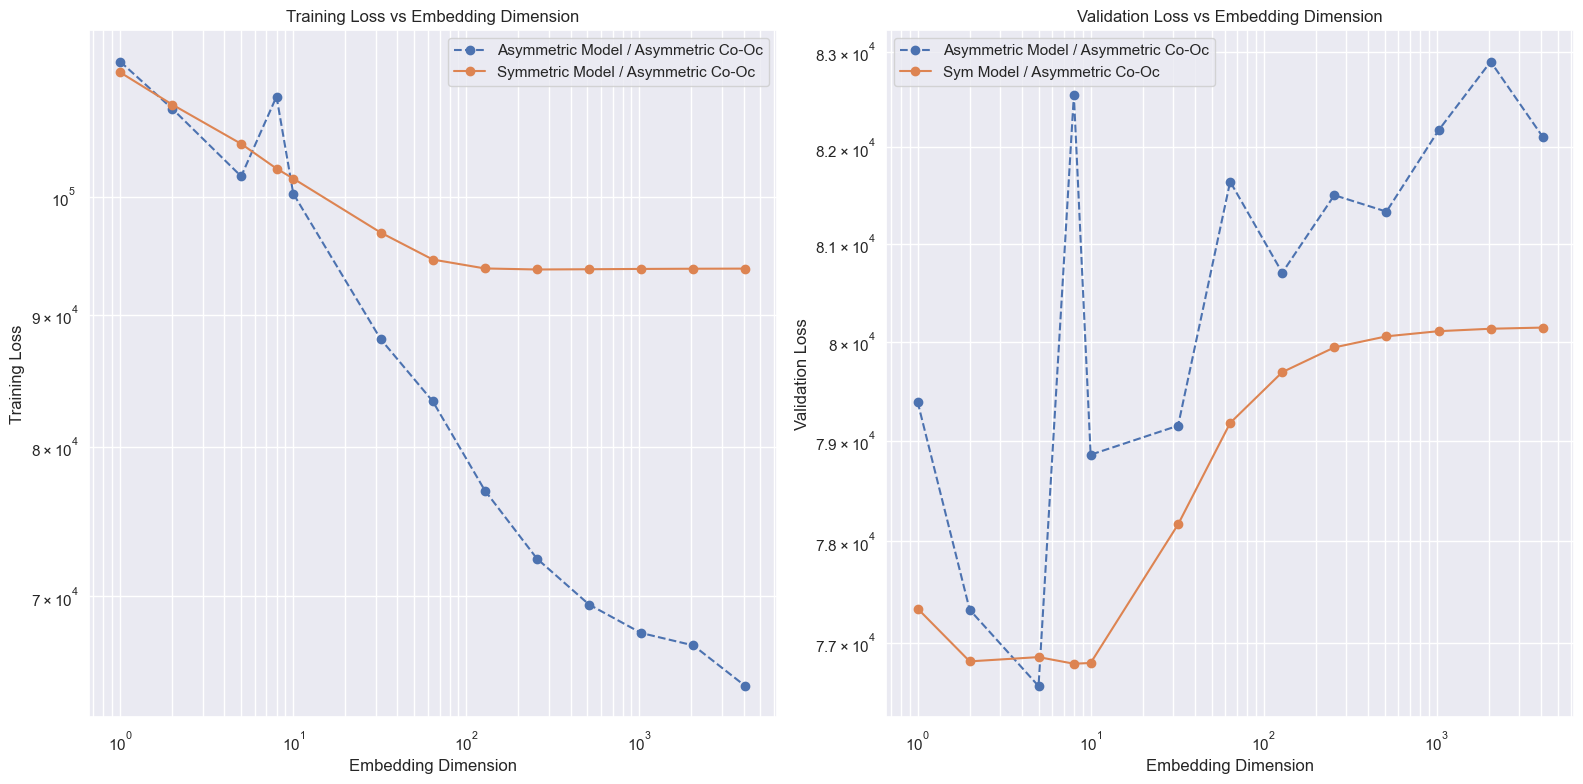

In [85]:
fig, ax = uks_mpl.subplots(2, 1, 8, 8)  # my personal matplotlib wrapper func
ax[0].loglog(
    embedding_dims,
    asymModel_asymCoOc_final_train_losses,
    label="Asymmetric Model / Asymmetric Co-Oc",
    marker="o",
    linestyle="--",
)
ax[0].loglog(
    embedding_dims,
    symModel_asymCoOc_final_train_losses,
    marker="o",
    label="Symmetric Model / Asymmetric Co-Oc",
)
ax[0].set_xlabel("Embedding Dimension")
ax[0].set_ylabel("Training Loss")

ax[1].loglog(
    embedding_dims,
    asymModel_asymCoOc_final_val_losses,
    label="Asymmetric Model / Asymmetric Co-Oc",
    linestyle="--",
    marker="o",
)
ax[1].loglog(
    embedding_dims,
    symModel_asymCoOc_final_val_losses,
    label="Sym Model / Asymmetric Co-Oc",
    marker="o",
)
ax[1].set_xlabel("Embedding Dimension")
ax[1].set_ylabel("Validation Loss")

ax[0].set_title("Training Loss vs Embedding Dimension")
ax[1].set_title("Validation Loss vs Embedding Dimension")


uks_mpl.style_axes(fig, ax)
fig


# Part 2: Training the model (26pts)

We will modify the architecture slightly from the previous section, inspired by BERT (Devlin et al., 2018). Instead of having only one output, the architecture will now take in $N=4$ context words, and also output predictions for $N=4$ words. See Figure 2 diagram in the handout for the diagram of this architecture.

During training, we randomly sample one of the $N$ context words to replace with a `[MASK]` token. The goal is for the network to predict the word that was masked, at the corresponding output word position.
In practice, this `[MASK]` token is assigned the index 0 in our dictionary.
The weights $W^{(2)}$ = `hid_to_output_weights` now has the shape $NV \times H$, as the output layer has $NV$ neurons, where the first $V$ output units are for predicting the first word, then the next $V$ are for predicting the second word, and so on.
    We call this as *concatenating* output uniits across all word positions, i.e. the $(j + nV)$-th column is for the word $j$ in vocabulary for the $n$-th output word position.
        Note here that the softmax is applied in chunks of $V$ as well, to give a valid probability distribution over the $V$ words. Only the output word positions that were masked in the input are included in the cross entropy loss calculation:
        
        
There are three classes defined in this part: `Params`, `Activations`, `Model`.
You will make changes to `Model`, but it may help to read through `Params` and `Activations` first.

$$C = -\sum_{i}^{B}\sum_{n}^{N}\sum_{j}^{V} m^{(i)}_{n} (t^{(i)}_{n,j} \log y^{(i)}_{n,j}),$$

Where $y^{(i)}_{n,j}$ denotes the output probability prediction from the neural network for the $i$-th training example for the word $j$ in the $n$-th output word, and $t^{(i)}_{n,j}$ is 1 if for the $i$-th training example, the word $j$ is the $n$-th word in context. Finally, $m^{(i)}_{n} \in \{0,1\}$ is a mask that is set to 1 if we are predicting the $n$-th word position for the $i$-th example (because we had masked that word in the input), and 0 otherwise.  


There are three classes defined in this part: `Params`, `Activations`, `Model`.
You will make changes to `Model`, but it may help to read through `Params` and `Activations` first.

In [86]:
class Params(object):
    """A class representing the trainable parameters of the model. This class has five fields:

    word_embedding_weights, a matrix of size V x D, where V is the number of words in the vocabulary
            and D is the embedding dimension.
    embed_to_hid_weights, a matrix of size H x ND, where H is the number of hidden units. The first D
            columns represent connections from the embedding of the first context word, the next D columns
            for the second context word, and so on. There are N context words.
    hid_bias, a vector of length H
    hid_to_output_weights, a matrix of size NV x H
    output_bias, a vector of length NV"""

    def __init__(
        self,
        word_embedding_weights: np.ndarray,
        embed_to_hid_weights: np.ndarray,
        hid_to_output_weights: np.ndarray,
        hid_bias: np.ndarray,
        output_bias: np.ndarray,
    ):
        self.word_embedding_weights = word_embedding_weights
        self.embed_to_hid_weights = embed_to_hid_weights
        self.hid_to_output_weights = hid_to_output_weights
        self.hid_bias = hid_bias
        self.output_bias = output_bias

    def copy(self):
        return self.__class__(
            self.word_embedding_weights.copy(),
            self.embed_to_hid_weights.copy(),
            self.hid_to_output_weights.copy(),
            self.hid_bias.copy(),
            self.output_bias.copy(),
        )

    @classmethod
    def zeros(cls, vocab_size: int, context_len: int, embedding_dim: int, num_hid: int):
        """A constructor which initializes all weights and biases to 0."""
        word_embedding_weights = np.zeros((vocab_size, embedding_dim))
        embed_to_hid_weights = np.zeros((num_hid, context_len * embedding_dim))
        hid_to_output_weights = np.zeros((vocab_size * context_len, num_hid))
        hid_bias = np.zeros(num_hid)
        output_bias = np.zeros(vocab_size * context_len)
        return cls(
            word_embedding_weights,
            embed_to_hid_weights,
            hid_to_output_weights,
            hid_bias,
            output_bias,
        )

    @classmethod
    def random_init(
        cls,
        init_wt: float,
        vocab_size: int,
        context_len: int,
        embedding_dim: int,
        num_hid: int,
    ):
        """A constructor which initializes weights to small random values and biases to 0."""
        word_embedding_weights = np.random.normal(
            0.0, init_wt, size=(vocab_size, embedding_dim)
        )
        embed_to_hid_weights = np.random.normal(
            0.0, init_wt, size=(num_hid, context_len * embedding_dim)
        )
        hid_to_output_weights = np.random.normal(
            0.0, init_wt, size=(vocab_size * context_len, num_hid)
        )
        hid_bias = np.zeros(num_hid)
        output_bias = np.zeros(vocab_size * context_len)
        return cls(
            word_embedding_weights,
            embed_to_hid_weights,
            hid_to_output_weights,
            hid_bias,
            output_bias,
        )

    ###### The functions below are Python's somewhat oddball way of overloading operators, so that
    ###### we can do arithmetic on Params instances. You don't need to understand this to do the assignment.

    def __mul__(self, a: float):
        return self.__class__(
            a * self.word_embedding_weights,
            a * self.embed_to_hid_weights,
            a * self.hid_to_output_weights,
            a * self.hid_bias,
            a * self.output_bias,
        )

    def __rmul__(self, a: float):
        return self * a

    def __add__(self, other: "Params"):
        return self.__class__(
            self.word_embedding_weights + other.word_embedding_weights,
            self.embed_to_hid_weights + other.embed_to_hid_weights,
            self.hid_to_output_weights + other.hid_to_output_weights,
            self.hid_bias + other.hid_bias,
            self.output_bias + other.output_bias,
        )

    def __sub__(self, other: "Params"):
        return self + -1.0 * other

In [87]:
class Activations(object):
    """A class representing the activations of the units in the network. This class has three fields:

    embedding_layer, a matrix of B x ND matrix (where B is the batch size, D is the embedding dimension,
            and N is the number of input context words), representing the activations for the embedding
            layer on all the cases in a batch. The first D columns represent the embeddings for the
            first context word, and so on.
    hidden_layer, a B x H matrix representing the hidden layer activations for a batch
    output_layer, a B x V matrix representing the output layer activations for a batch
    """

    def __init__(
        self,
        embedding_layer: np.ndarray,
        hidden_layer: np.ndarray,
        output_layer: np.ndarray,
    ):
        self.embedding_layer = embedding_layer
        self.hidden_layer = hidden_layer
        self.output_layer = output_layer


def get_batches(inputs: np.ndarray, batch_size: int, shuffle: bool = True):
    """Divide a dataset (usually the training set) into mini-batches of a given size. This is a
    'generator', i.e. something you can use in a for loop. You don't need to understand how it
    works to do the assignment."""

    if inputs.shape[0] % batch_size != 0:
        raise RuntimeError(
            "The number of data points must be a multiple of the batch size."
        )
    num_batches = inputs.shape[0] // batch_size

    if shuffle:
        idxs = np.random.permutation(inputs.shape[0])
        inputs = inputs[idxs, :]

    for m in range(num_batches):
        yield inputs[m * batch_size : (m + 1) * batch_size, :]

In this part of the assignment, you implement a method which computes the gradient using backpropagation.
To start you out, the *Model* class contains several important methods used in training:


*   `compute_activations` computes the activations of all units on a given input batch
*   `compute_loss` computes the total cross-entropy loss on a mini-batch
*   `evaluate` computes the average cross-entropy loss for a given set of inputs and targets

You will need to complete the implementation of two additional methods which are needed for training, and print the outputs of the gradients.

 ## 2.1 Implement gradient with respect to output layer inputs [8pts]
* [ ] **TO BE IMPLEMENTED**: `compute_loss_derivative` computes the derivative of the loss function with respect to the output layer inputs.

In other words, if $C$ is the cost function, and the softmax computation for the $j$-th word in vocabulary for the $n$-th output word position is:

$$y_{n,j} = \frac{e^{z_{n,j}}}{\sum_{l} e^{z_{n,l   }}}$$

This function should compute a $B \times NV$ matrix where the entries correspond to the partial derivatives $\partial C / \partial z_{j}^{n}$. Recall that the output units are concatenated across all positions, i.e. the $(j + nV)$-th column is for the word $j$ in vocabulary for the $n$-th output word position.

## 2.2 Implement gradient with respect to parameters [8pts]
* [ ] **TO BE IMPLEMENTED**: `back_propagate` is the function which computes the gradient of the loss with respect to model parameters using backpropagation.
It uses the derivatives computed by *compute_loss_derivative*.
Some parts are already filled in for you, but you need to compute the matrices of derivatives for `embed_to_hid_weights`, `hid_bias`, `hid_to_output_weights`, and `output_bias`.
These matrices have the same sizes as the parameter matrices (see previous section).

In order to implement backpropagation efficiently, you need to express the computations in terms of matrix operations, rather than *for* loops.
You should first work through the derivatives on pencil and paper.
First, apply the chain rule to compute the derivatives with respect to individual units, weights, and biases.
Next, take the formulas you've derived, and express them in matrix form.
You should be able to express all of the required computations using only matrix multiplication, matrix transpose, and elementwise operations --- no *for* loops!
If you want inspiration, read through the code for *Model.compute_activations* and try to understand how the matrix operations correspond to the computations performed by all the units in the network.
        
To make your life easier, we have provided the routine `checking.check_gradients`, which checks your gradients using finite differences.
You should make sure this check passes before continuing with the assignment.



In [88]:
class Model(object):
    """A class representing the language model itself. This class contains various methods used in training
    the model and visualizing the learned representations. It has two fields:

        params, a Params instance which contains the model parameters
        vocab, a list containing all the words in the dictionary; vocab[0] is the word with index
               0, and so on."""

    def __init__(self, params: Params, vocab: list[str]):
        self.params = params
        self.vocab = vocab

        self.vocab_size = len(vocab)
        self.embedding_dim = self.params.word_embedding_weights.shape[1]
        self.embedding_layer_dim = self.params.embed_to_hid_weights.shape[1]
        self.context_len = self.embedding_layer_dim // self.embedding_dim
        self.num_hid = self.params.embed_to_hid_weights.shape[0]

    def copy(self):
        return self.__class__(self.params.copy(), self.vocab[:])

    @classmethod
    def random_init(
        cls,
        init_wt: float,
        vocab: list,
        context_len: int,
        embedding_dim: int,
        num_hid: int,
    ):
        """Constructor which randomly initializes the weights to Gaussians with standard deviation init_wt
        and initializes the biases to all zeros."""
        params = Params.random_init(
            init_wt, len(vocab), context_len, embedding_dim, num_hid
        )
        return Model(params, vocab)

    def indicator_matrix(
        self, targets: np.ndarray, mask_zero_index: bool = True
    ) -> np.ndarray:
        """Construct a matrix where the (k + j*V)th entry of row i is 1 if the j-th target word
        for example i is k, and all other entries are 0.

        Note: if the j-th target word index is 0, this corresponds to the [MASK] token,
              and we set the entry to be 0.
        """
        batch_size, context_len = targets.shape
        expanded_targets = np.zeros((batch_size, context_len * len(self.vocab)))
        targets_offset = np.repeat(
            (np.arange(context_len) * len(self.vocab))[np.newaxis, :],
            batch_size,
            axis=0,
        )  # [[0, V, 2V], [0, V, 2V], ...]
        targets += targets_offset

        for c in range(context_len):
            expanded_targets[np.arange(batch_size), targets[:, c]] = 1.0
            if mask_zero_index:
                # Note: Set the targets with index 0, V, 2V to be zero since it corresponds to the [MASK] token
                expanded_targets[np.arange(batch_size), targets_offset[:, c]] = 0.0
        return expanded_targets

    def compute_loss_derivative(
        self,
        output_activations: np.ndarray,
        expanded_target_batch: np.ndarray,
        target_mask: np.ndarray,
    ):
        r"""Compute the derivative of the multiple target position cross-entropy loss function \n"

            For example:

         [y_{0} ....  y_{V-1}] [y_{V}, ..., y_{2*V-1}] [y_{2*V} ... y_{i,3*V-1}] [y_{3*V} ... y_{i,4*V-1}]

         Where for colum j + n*V,

            y_{j + n*V} = e^{z_{j + n*V}} / \sum_{m=0}^{V-1} e^{z_{m + n*V}}, for n=0,...,N-1

        This function should return a dC / dz matrix of size [batch_size x (vocab_size * context_len)],
        where each row i in dC / dz has columns 0 to V-1 containing the gradient the 1st output
        context word from i-th training example, then columns vocab_size to 2*vocab_size - 1 for the 2nd
        output context word of the i-th training example, etc.

        C is the loss function summed acrossed all examples as well:

            C = -\sum_{i,j,n} mask_{i,n} (t_{i, j + n*V} log y_{i, j + n*V}), for j=0,...,V, and n=0,...,N

        where mask_{i,n} = 1 if the i-th training example has n-th context word as the target,
        otherwise mask_{i,n} = 0.

        The arguments are as follows:

            output_activations - A [batch_size x (context_len * vocab_size)] tensor,
                for the activations of the output layer, i.e. the y_j's.
            expanded_target_batch - A [batch_size (context_len * vocab_size)] tensor,
                where expanded_target_batch[i,n*V:(n+1)*V] is the indicator vector for
                the n-th context target word position, i.e. the (i, j + n*V) entry is 1 if the
                i'th example, the context word at position n is j, and 0 otherwise.
            target_mask - A [batch_size x context_len x 1] tensor, where target_mask[i,n] = 1
                if for the i'th example the n-th context word is a target position, otherwise 0

        Outputs:
            loss_derivative - A [batch_size x (context_len * vocab_size)] matrix,
                where loss_derivative[i,0:vocab_size] contains the gradient
                dC / dz_0 for the i-th training example gradient for 1st output
                context word, and loss_derivative[i,vocab_size:2*vocab_size] for
                the 2nd output context word of the i-th training example, etc.
        """

        ###########################   YOUR CODE HERE  ##############################
        # Reshape output_activations and expanded_target_batch for easier computation
        batch_size = output_activations.shape[0]
        context_len = self.context_len
        vocab_size = self.vocab_size

        output_activations_reshaped = output_activations.reshape(
            batch_size, context_len, vocab_size
        )
        expanded_target_batch_reshaped = expanded_target_batch.reshape(
            batch_size, context_len, vocab_size
        )
        target_mask_reshaped = target_mask.reshape(batch_size, context_len, 1)

        # Compute the loss derivative: dC/dz = y - t, masked
        loss_derivative = (
            output_activations_reshaped - expanded_target_batch_reshaped
        ) * target_mask_reshaped

        loss_derivative = loss_derivative.reshape(batch_size, context_len * vocab_size)

        # print(
        #     loss_derivative,
        #     output_activations.shape,
        #     expanded_target_batch.shape,
        #     target_mask.shape,
        # )
        return loss_derivative

        ############################################################################

    def compute_loss(
        self, output_activations: np.ndarray, expanded_target_batch: np.ndarray
    ) -> float:
        """Compute the total loss over a mini-batch. expanded_target_batch is the matrix obtained
        by calling indicator_matrix on the targets for the batch."""
        return -np.sum(expanded_target_batch * np.log(output_activations + TINY))

    def compute_activations(self, inputs: np.ndarray) -> Activations:
        """Compute the activations on a batch given the inputs. Returns an Activations instance.
        You should try to read and understand this function, since this will give you clues for
        how to implement back_propagate."""

        batch_size = inputs.shape[0]
        if inputs.shape[1] != self.context_len:
            raise RuntimeError(
                f"Dimension of the input vectors should be {self.context_len}, but is instead {inputs.shape[1]}"
            )

        # Embedding layer
        # Look up the input word indies in the word_embedding_weights matrix
        embedding_layer_state = np.zeros((batch_size, self.embedding_layer_dim))
        for i in range(self.context_len):
            embedding_layer_state[
                :, i * self.embedding_dim : (i + 1) * self.embedding_dim
            ] = self.params.word_embedding_weights[inputs[:, i], :]

        # Hidden layer
        inputs_to_hid = (
            np.dot(embedding_layer_state, self.params.embed_to_hid_weights.T)
            + self.params.hid_bias
        )
        # Apply logistic activation function
        hidden_layer_state = 1.0 / (1.0 + np.exp(-inputs_to_hid))

        # Output layer
        inputs_to_softmax = (
            np.dot(hidden_layer_state, self.params.hid_to_output_weights.T)
            + self.params.output_bias
        )

        # Subtract maximum.
        # Remember that adding or subtracting the same constant from each input to a
        # softmax unit does not affect the outputs. So subtract the maximum to
        # make all inputs <= 0. This prevents overflows when computing their exponents.
        inputs_to_softmax -= inputs_to_softmax.max(1).reshape((-1, 1))

        # Take softmax along each V chunks in the output layer
        output_layer_state = np.exp(inputs_to_softmax)
        output_layer_state_shape = output_layer_state.shape
        output_layer_state = output_layer_state.reshape(
            (-1, self.context_len, len(self.vocab))
        )
        output_layer_state /= output_layer_state.sum(
            axis=-1, keepdims=True
        )  # Softmax along each target word
        output_layer_state = output_layer_state.reshape(
            output_layer_state_shape
        )  # Flatten back

        return Activations(
            embedding_layer_state, hidden_layer_state, output_layer_state
        )

    def back_propagate(
        self,
        input_batch: np.ndarray,
        activations: Activations,
        loss_derivative: np.ndarray,
    ) -> Params:
        """Compute the gradient of the loss function with respect to the trainable parameters
        of the model. The arguments are as follows:

             input_batch - the indices of the context words
             activations - an Activations class representing the output of Model.compute_activations
             loss_derivative - the matrix of derivatives computed by compute_loss_derivative

        Part of this function is already completed, but you need to fill in the derivative
        computations for hid_to_output_weights_grad, output_bias_grad, embed_to_hid_weights_grad,
        and hid_bias_grad. See the documentation for the Params class for a description of what
        these matrices represent."""

        # The matrix with values dC / dz_j, where dz_j is the input to the jth hidden unit,
        # i.e. h_j = 1 / (1 + e^{-z_j})
        hid_deriv: np.ndarray = (
            np.dot(loss_derivative, self.params.hid_to_output_weights)
            * activations.hidden_layer
            * (1.0 - activations.hidden_layer)
        )

        ###########################   YOUR CODE HERE  ##############################
        hid_to_output_weights_grad: np.ndarray = (
            loss_derivative.T @ activations.hidden_layer
        )
        output_bias_grad: np.ndarray = np.sum(loss_derivative, axis=0)
        embed_to_hid_weights_grad: np.ndarray = (
            hid_deriv.T @ activations.embedding_layer
        )
        hid_bias_grad: np.ndarray = np.sum(hid_deriv, axis=0)
        ############################################################################

        # The matrix of derivatives for the embedding layer
        embed_deriv = np.dot(hid_deriv, self.params.embed_to_hid_weights)

        # Embedding layer
        word_embedding_weights_grad = np.zeros((self.vocab_size, self.embedding_dim))
        for w in range(self.context_len):
            word_embedding_weights_grad += np.dot(
                self.indicator_matrix(
                    input_batch[:, w : w + 1], mask_zero_index=False
                ).T,
                embed_deriv[:, w * self.embedding_dim : (w + 1) * self.embedding_dim],
            )

        return Params(
            word_embedding_weights_grad,
            embed_to_hid_weights_grad,
            hid_to_output_weights_grad,
            hid_bias_grad,
            output_bias_grad,
        )

    def sample_input_mask(self, batch_size: int) -> np.ndarray:
        """Samples a binary mask for the inputs of size batch_size x context_len
        For each row, at most one element will be 1.
        """
        mask_idx = np.random.randint(self.context_len, size=(batch_size,))
        mask = np.zeros(
            (batch_size, self.context_len), dtype=int
        )  # Convert to one hot B x N, B batch size, N context len
        mask[np.arange(batch_size), mask_idx] = 1
        return mask

    def evaluate(self, inputs: np.ndarray, batch_size: int = 100):
        """Compute the average cross-entropy over a dataset.

        inputs: matrix of shape D x N"""

        ndata = inputs.shape[0]

        total = 0.0
        for input_batch in get_batches(inputs, batch_size):
            mask = self.sample_input_mask(batch_size)
            input_batch_masked = input_batch * (1 - mask)
            activations = self.compute_activations(input_batch_masked)
            target_batch_masked = input_batch * mask
            expanded_target_batch = self.indicator_matrix(target_batch_masked)
            cross_entropy = -np.sum(
                expanded_target_batch * np.log(activations.output_layer + TINY)
            )
            total += cross_entropy

        return total / float(ndata)

    def display_nearest_words(self, word: str, k: int = 10):
        """List the k words nearest to a given word, along with their distances."""

        if word not in self.vocab:
            print(f'Word "{word}" not in vocabulary.')
            return

        # Compute distance to every other word.
        idx = self.vocab.index(word)
        word_rep = self.params.word_embedding_weights[idx, :]
        diff = self.params.word_embedding_weights - word_rep.reshape((1, -1))
        distance = np.sqrt(np.sum(diff**2, axis=1))

        # Sort by distance.
        order = np.argsort(distance)
        order = order[
            1 : 1 + k
        ]  # The nearest word is the query word itself, skip that.
        for i in order:
            print(f"{self.vocab[i]}: {distance[i]}")

    def word_distance(self, word1: str, word2: str) -> float:
        """Compute the distance between the vector representations of two words."""

        if word1 not in self.vocab:
            raise RuntimeError(f'Word "{word1}" not in vocabulary.')
        if word2 not in self.vocab:
            raise RuntimeError(f'Word "{word2}" not in vocabulary.')

        idx1, idx2 = self.vocab.index(word1), self.vocab.index(word2)
        word_rep1 = self.params.word_embedding_weights[idx1, :]
        word_rep2 = self.params.word_embedding_weights[idx2, :]
        diff = word_rep1 - word_rep2
        return np.sqrt(np.sum(diff**2))

## 2.3 Print the gradients [8pts]

To make your life easier, we have provided the routine `check_gradients`, which checks your gradients using finite differences.
        You should make sure this check passes before continuing with the assignment. Once `check_gradients()` passes, call `print_gradients()` and include its output in your write-up.

In [89]:
def relative_error(a: float, b: float):
    return np.abs(a - b) / (np.abs(a) + np.abs(b))


def check_output_derivatives(
    model: Model, input_batch: np.ndarray, target_batch: np.ndarray
):
    def softmax(z):
        z = z.copy()
        z -= z.max(-1, keepdims=True)
        y = np.exp(z)
        y /= y.sum(-1, keepdims=True)
        return y

    batch_size = input_batch.shape[0]
    z = np.random.normal(size=(batch_size, model.context_len, model.vocab_size))
    y = softmax(z).reshape((batch_size, model.context_len * model.vocab_size))
    z = z.reshape((batch_size, model.context_len * model.vocab_size))

    expanded_target_batch = model.indicator_matrix(target_batch)
    target_mask = expanded_target_batch.reshape(
        -1, model.context_len, len(model.vocab)
    ).sum(axis=-1, keepdims=True)
    loss_derivative = model.compute_loss_derivative(
        y, expanded_target_batch, target_mask
    )

    if loss_derivative is None:
        print("Loss derivative not implemented yet.")
        return False

    if loss_derivative.shape != (batch_size, model.vocab_size * model.context_len):
        print(
            "Loss derivative should be size {} but is actually {}.".format(
                (batch_size, model.vocab_size), loss_derivative.shape
            )
        )
        return False

    def obj(z: np.ndarray):
        z = z.reshape((-1, model.context_len, model.vocab_size))
        y = softmax(z).reshape((batch_size, model.context_len * model.vocab_size))
        return model.compute_loss(y, expanded_target_batch)

    for count in range(1000):
        i, j = np.random.randint(0, loss_derivative.shape[0]), np.random.randint(
            0, loss_derivative.shape[1]
        )

        z_plus = z.copy()
        z_plus[i, j] += EPS
        obj_plus = obj(z_plus)

        z_minus = z.copy()
        z_minus[i, j] -= EPS
        obj_minus = obj(z_minus)

        empirical = (obj_plus - obj_minus) / (2.0 * EPS)
        rel = relative_error(empirical, loss_derivative[i, j])
        if rel > 1e-4:
            print(
                "The loss derivative has a relative error of {}, which is too large.".format(
                    rel
                )
            )
            return False

    print("The loss derivative looks OK.")
    return True


def check_param_gradient(
    model: Model, param_name: str, input_batch: np.ndarray, target_batch: np.ndarray
):
    activations = model.compute_activations(input_batch)
    expanded_target_batch = model.indicator_matrix(target_batch)
    target_mask = expanded_target_batch.reshape(
        -1, model.context_len, len(model.vocab)
    ).sum(axis=-1, keepdims=True)
    loss_derivative = model.compute_loss_derivative(
        activations.output_layer, expanded_target_batch, target_mask
    )
    param_gradient = model.back_propagate(input_batch, activations, loss_derivative)

    def obj(model: Model):
        activations = model.compute_activations(input_batch)
        return model.compute_loss(activations.output_layer, expanded_target_batch)

    dims = t.cast(np.ndarray, getattr(model.params, param_name)).shape
    is_matrix = len(dims) == 2

    if getattr(param_gradient, param_name).shape != dims:
        print(
            "The gradient for {} should be size {} but is actually {}.".format(
                param_name, dims, getattr(param_gradient, param_name).shape
            )
        )
        return

    for count in range(1000):
        if is_matrix:
            slc = np.random.randint(0, dims[0]), np.random.randint(0, dims[1])
        else:
            slc = np.random.randint(dims[0])

        model_plus = model.copy()
        getattr(model_plus.params, param_name)[slc] += EPS
        obj_plus = obj(model_plus)

        model_minus = model.copy()
        getattr(model_minus.params, param_name)[slc] -= EPS
        obj_minus = obj(model_minus)

        empirical = (obj_plus - obj_minus) / (2.0 * EPS)
        exact = getattr(param_gradient, param_name)[slc]
        rel = relative_error(empirical, exact)
        if rel > 3e-4:
            import pdb

            pdb.set_trace()
            print(
                "The loss derivative has a relative error of {}, which is too large for param {}.".format(
                    rel, param_name
                )
            )
            return False

    print("The gradient for {} looks OK.".format(param_name))


def load_partially_trained_model():
    obj = pickle.load(open(PARTIALLY_TRAINED_MODEL, "rb"))
    params = Params(
        obj["word_embedding_weights"],
        obj["embed_to_hid_weights"],
        obj["hid_to_output_weights"],
        obj["hid_bias"],
        obj["output_bias"],
    )
    vocab = obj["vocab"]
    return Model(params, vocab)


def check_gradients():
    """Check the computed gradients using finite differences."""
    np.random.seed(0)

    np.seterr(all="ignore")  # suppress a warning which is harmless

    model = load_partially_trained_model()
    data_obj = pickle.load(open(data_location, "rb"))
    train_inputs = data_obj["train_inputs"]
    input_batch = train_inputs[:100, :]
    mask = model.sample_input_mask(input_batch.shape[0])
    input_batch_masked = input_batch * (1 - mask)
    target_batch_masked = input_batch * mask

    if not check_output_derivatives(model, input_batch_masked, target_batch_masked):
        return

    for param_name in [
        "word_embedding_weights",
        "embed_to_hid_weights",
        "hid_to_output_weights",
        "hid_bias",
        "output_bias",
    ]:
        input_batch_masked = input_batch * (1 - mask)
        target_batch_masked = input_batch * mask
        check_param_gradient(model, param_name, input_batch_masked, target_batch_masked)


def print_gradients():
    """Print out certain derivatives for grading."""
    np.random.seed(0)

    model = load_partially_trained_model()
    data_obj = pickle.load(open(data_location, "rb"))
    train_inputs = data_obj["train_inputs"]
    input_batch = train_inputs[:100, :]

    mask = model.sample_input_mask(input_batch.shape[0])
    input_batch_masked = input_batch * (1 - mask)
    activations = model.compute_activations(input_batch_masked)
    target_batch_masked = input_batch * mask
    expanded_target_batch = model.indicator_matrix(target_batch_masked)
    target_mask = expanded_target_batch.reshape(
        -1, model.context_len, len(model.vocab)
    ).sum(axis=-1, keepdims=True)
    loss_derivative = model.compute_loss_derivative(
        activations.output_layer, expanded_target_batch, target_mask
    )
    param_gradient = model.back_propagate(input_batch, activations, loss_derivative)

    print("loss_derivative[2, 5]", loss_derivative[2, 5])
    print("loss_derivative[2, 121]", loss_derivative[2, 121])
    print("loss_derivative[5, 33]", loss_derivative[5, 33])
    print("loss_derivative[5, 31]", loss_derivative[5, 31])
    print()
    print(
        "param_gradient.word_embedding_weights[27, 2]",
        param_gradient.word_embedding_weights[27, 2],
    )
    print(
        "param_gradient.word_embedding_weights[43, 3]",
        param_gradient.word_embedding_weights[43, 3],
    )
    print(
        "param_gradient.word_embedding_weights[22, 4]",
        param_gradient.word_embedding_weights[22, 4],
    )
    print(
        "param_gradient.word_embedding_weights[2, 5]",
        param_gradient.word_embedding_weights[2, 5],
    )
    print()
    print(
        "param_gradient.embed_to_hid_weights[10, 2]",
        param_gradient.embed_to_hid_weights[10, 2],
    )
    print(
        "param_gradient.embed_to_hid_weights[15, 3]",
        param_gradient.embed_to_hid_weights[15, 3],
    )
    print(
        "param_gradient.embed_to_hid_weights[30, 9]",
        param_gradient.embed_to_hid_weights[30, 9],
    )
    print(
        "param_gradient.embed_to_hid_weights[35, 21]",
        param_gradient.embed_to_hid_weights[35, 21],
    )
    print()
    print("param_gradient.hid_bias[10]", param_gradient.hid_bias[10])
    print("param_gradient.hid_bias[20]", param_gradient.hid_bias[20])
    print()
    print("param_gradient.output_bias[0]", param_gradient.output_bias[0])
    print("param_gradient.output_bias[1]", param_gradient.output_bias[1])
    print("param_gradient.output_bias[2]", param_gradient.output_bias[2])
    print("param_gradient.output_bias[3]", param_gradient.output_bias[3])

In [90]:
# Run this to check if your implement gradients matches the finite difference within tolerance
# Note: this may take a few minutes to go through all the checks
check_gradients()

The loss derivative looks OK.
The gradient for word_embedding_weights looks OK.
The gradient for embed_to_hid_weights looks OK.
The gradient for hid_to_output_weights looks OK.
The gradient for hid_bias looks OK.
The gradient for output_bias looks OK.


In [91]:
# Run this to print out the gradients
print_gradients()

loss_derivative[2, 5] 0.0
loss_derivative[2, 121] 0.0
loss_derivative[5, 33] 0.0
loss_derivative[5, 31] 0.0

param_gradient.word_embedding_weights[27, 2] 0.0
param_gradient.word_embedding_weights[43, 3] 0.01159689251148945
param_gradient.word_embedding_weights[22, 4] -0.022267062381729714
param_gradient.word_embedding_weights[2, 5] 0.0

param_gradient.embed_to_hid_weights[10, 2] 0.3793257091930164
param_gradient.embed_to_hid_weights[15, 3] 0.01604516132110911
param_gradient.embed_to_hid_weights[30, 9] -0.4312854367997418
param_gradient.embed_to_hid_weights[35, 21] 0.06679896665436336

param_gradient.hid_bias[10] 0.023428803123345162
param_gradient.hid_bias[20] -0.02437045237887423

param_gradient.output_bias[0] 0.000970106146902794
param_gradient.output_bias[1] 0.1686894627476322
param_gradient.output_bias[2] 0.0051664774143909235
param_gradient.output_bias[3] 0.1509622647181436


## 2.4 Run model training [2pts]

Once you've implemented the gradient computation, you'll need to train the model.
The function *train* implements the main training procedure.
It takes two arguments:


*   `embedding_dim`: The number of dimensions in the distributed representation.
*   `num_hid`: The number of hidden units


As the model trains, the script prints out some numbers that tell you how well the training is going.
It shows:


*   The cross entropy on the last 100 mini-batches of the training set. This is shown after every 100 mini-batches.
*   The cross entropy on the entire validation set every 1000 mini-batches of training.

At the end of training, this function shows the cross entropies on the training, validation and test sets.
It will return a *Model* instance.

In [92]:
data_obj = pickle.load(open(data_location, "rb"))
type(data_obj["vocab"])

list

In [93]:
_train_inputs: np.ndarray = np.array([])
_train_targets: np.ndarray = np.array([])
_vocab = []

DEFAULT_TRAINING_CONFIG = {
    "batch_size": 100,  # the size of a mini-batch
    "learning_rate": 0.1,  # the learning rate
    "momentum": 0.9,  # the decay parameter for the momentum vector
    "epochs": 50,  # the maximum number of epochs to run
    "init_wt": 0.01,  # the standard deviation of the initial random weights
    "context_len": 4,  # the number of context words used
    "show_training_CE_after": 100,  # measure training error after this many mini-batches
    "show_validation_CE_after": 1000,  # measure validation error after this many mini-batches
}


def find_occurrences(word1: str, word2: str, word3: str):
    """Lists all the words that followed a given tri-gram in the training set and the number of
    times each one followed it."""

    # cache the data so we don't keep reloading
    global _train_inputs, _train_targets, _vocab
    if _train_inputs is None:
        data_obj = pickle.load(open(data_location, "rb"))
        _vocab = data_obj["vocab"]
        _train_inputs, _train_targets = (
            data_obj["train_inputs"],
            data_obj["train_targets"],
        )

    if word1 not in _vocab:
        raise RuntimeError('Word "{}" not in vocabulary.'.format(word1))
    if word2 not in _vocab:
        raise RuntimeError('Word "{}" not in vocabulary.'.format(word2))
    if word3 not in _vocab:
        raise RuntimeError('Word "{}" not in vocabulary.'.format(word3))

    idx1, idx2, idx3 = _vocab.index(word1), _vocab.index(word2), _vocab.index(word3)
    idxs = np.array([idx1, idx2, idx3])

    matches = np.all(_train_inputs == idxs.reshape((1, -1)), 1)

    if np.any(matches):
        counts = collections.defaultdict(int)
        for m in np.where(matches)[0]:
            counts[_vocab[_train_targets[m]]] += 1

        word_counts = sorted(list(counts.items()), key=lambda t: t[1], reverse=True)
        print(
            'The tri-gram "{} {} {}" was followed by the following words in the training set:'.format(
                word1, word2, word3
            )
        )
        for word, count in word_counts:
            if count > 1:
                print("    {} ({} times)".format(word, count))
            else:
                print("    {} (1 time)".format(word))
    else:
        print(
            'The tri-gram "{} {} {}" did not occur in the training set.'.format(
                word1, word2, word3
            )
        )


def train(embedding_dim: int, num_hid: int, config: dict = DEFAULT_TRAINING_CONFIG):
    """This is the main training routine for the language model. It takes two parameters:

    embedding_dim, the dimension of the embedding space
    num_hid, the number of hidden units."""
    # For reproducibility
    np.random.seed(123)

    # Load the data
    data_obj = pickle.load(open(data_location, "rb"))
    vocab = data_obj["vocab"]
    train_inputs = data_obj["train_inputs"]
    valid_inputs = data_obj["valid_inputs"]
    test_inputs = data_obj["test_inputs"]

    # Randomly initialize the trainable parameters
    model = Model.random_init(
        config["init_wt"], vocab, config["context_len"], embedding_dim, num_hid
    )

    # Variables used for early stopping
    best_valid_CE = np.inf
    end_training = False

    # Initialize the momentum vector to all zeros
    delta = Params.zeros(len(vocab), config["context_len"], embedding_dim, num_hid)

    this_chunk_CE = 0.0
    batch_count = 0
    for epoch in range(1, config["epochs"] + 1):
        if end_training:
            break

        print()
        print("Epoch", epoch)

        for m, (input_batch) in enumerate(
            get_batches(train_inputs, config["batch_size"])
        ):
            batch_count += 1

            # For each example (row in input_batch), select one word to mask out
            mask = model.sample_input_mask(config["batch_size"])
            input_batch_masked = input_batch * (
                1 - mask
            )  # We only zero out one word per row
            target_batch_masked = (
                input_batch * mask
            )  # We want to predict the masked out word

            # Forward propagate
            activations = model.compute_activations(input_batch_masked)

            # Compute loss derivative
            expanded_target_batch = model.indicator_matrix(target_batch_masked)
            loss_derivative = model.compute_loss_derivative(
                activations.output_layer, expanded_target_batch, mask[:, :, np.newaxis]
            )
            loss_derivative /= config["batch_size"]

            # Measure loss function
            cross_entropy = (
                model.compute_loss(activations.output_layer, expanded_target_batch)
                / config["batch_size"]
            )
            this_chunk_CE += cross_entropy
            if batch_count % config["show_training_CE_after"] == 0:
                print(
                    "Batch {} Train CE {:1.3f}".format(
                        batch_count, this_chunk_CE / config["show_training_CE_after"]
                    )
                )
                this_chunk_CE = 0.0

            # Backpropagate
            loss_gradient = model.back_propagate(
                input_batch, activations, loss_derivative
            )

            # Update the momentum vector and model parameters
            delta = config["momentum"] * delta + loss_gradient
            model.params -= config["learning_rate"] * delta

            # Validate
            if batch_count % config["show_validation_CE_after"] == 0:
                print("Running validation...")
                cross_entropy = model.evaluate(valid_inputs)
                print("Validation cross-entropy: {:1.3f}".format(cross_entropy))

                if cross_entropy > best_valid_CE:
                    print("Validation error increasing!  Training stopped.")
                    end_training = True
                    break

                best_valid_CE = cross_entropy

    print()
    train_CE = model.evaluate(train_inputs)
    print("Final training cross-entropy: {:1.3f}".format(train_CE))
    valid_CE = model.evaluate(valid_inputs)
    print("Final validation cross-entropy: {:1.3f}".format(valid_CE))
    test_CE = model.evaluate(test_inputs)
    print("Final test cross-entropy: {:1.3f}".format(test_CE))

    return model

Run the training.


In [94]:
embedding_dim = 16
num_hid = 128
trained_model = train(embedding_dim, num_hid)


Epoch 1
Batch 100 Train CE 4.793
Batch 200 Train CE 4.645
Batch 300 Train CE 4.649
Batch 400 Train CE 4.629
Batch 500 Train CE 4.633
Batch 600 Train CE 4.648
Batch 700 Train CE 4.617
Batch 800 Train CE 4.607
Batch 900 Train CE 4.606
Batch 1000 Train CE 4.615
Running validation...
Validation cross-entropy: 4.615
Batch 1100 Train CE 4.615
Batch 1200 Train CE 4.624
Batch 1300 Train CE 4.608
Batch 1400 Train CE 4.595
Batch 1500 Train CE 4.611
Batch 1600 Train CE 4.598
Batch 1700 Train CE 4.577
Batch 1800 Train CE 4.578
Batch 1900 Train CE 4.568
Batch 2000 Train CE 4.589
Running validation...
Validation cross-entropy: 4.589
Batch 2100 Train CE 4.573
Batch 2200 Train CE 4.611
Batch 2300 Train CE 4.562
Batch 2400 Train CE 4.587
Batch 2500 Train CE 4.589
Batch 2600 Train CE 4.587
Batch 2700 Train CE 4.561
Batch 2800 Train CE 4.544
Batch 2900 Train CE 4.521
Batch 3000 Train CE 4.524
Running validation...
Validation cross-entropy: 4.496
Batch 3100 Train CE 4.504
Batch 3200 Train CE 4.449
Batch 

To convince us that you have correctly implemented the gradient computations, please include the following with your assignment submission:

* [ ] You will submit `hw1_code_<YOUR_UNI>.ipynb` through CourseWorks.
You do not need to modify any of the code except the parts we asked you to implement.
* [ ] In your PDF file, include the output of the function `print_gradients`.
This prints out part of the gradients for a partially trained network which we have provided, and we will check them against the correct outputs. **Important:** make sure to give the output of `print_gradients`, **not** `check_gradients`.

Since we gave you a gradient checker, you have no excuse for not getting full points on this part.


# Part 3: Arithmetics and Analysis (8pts)
In this part, you will perform arithmetic calculations on the word embeddings learned from previous models and analyze the representation learned by the networks with t-SNE plots.
    

## 3.1 t-SNE

You will first train the models discussed in the previous sections; you'll use the trained models for the remainding of this section.

**Important**: if you've made any fixes to your gradient code, you must reload the a1-code module and then re-run the training procedure.
Python does not reload modules automatically, and you don't want to accidentally
analyze an old version of your model.

These methods of the Model class can be used for analyzing the model after the training is
done:
* `tsne_plot_representation` creates a 2-dimensional embedding of the distributed representation space using an algorithm called t-SNE. (You don’t need to know what this is for the assignment, but we
may cover it later in the course.) Nearby points in this 2-D space are meant to correspond to
nearby points in the 16-D space.
*   `display_nearest_words` lists the words whose embedding vectors are nearest to the given
word
*   `word_distance` computes the distance between the embeddings of two words

Plot the 2-dimensional visualization for the trained model from part 3 using the method `tsne_plot_representation`.
            Look at the plot and find a few clusters of related words.
            What do the words in each cluster have in common?
            Plot the 2-dimensional visualization for the GloVe model from part 1 using the method `tsne_plot_GLoVe_representation`.
            How do the t-SNE embeddings for both models compare?
            Plot the 2-dimensional visualization using the method `plot_2d_GLoVe_representation`.
            How does this compare to the t-SNE embeddings?
            Please answer in 2 sentences for each question and show the plots in your submission.

In [ ]:
from sklearn.manifold import TSNE


def tsne_plot_representation(model: Model):
    """Plot a 2-D visualization of the learned representations using t-SNE."""
    mapped_X = TSNE(n_components=2).fit_transform(model.params.word_embedding_weights)
    pylab.figure(figsize=(12, 12))
    for i, w in enumerate(model.vocab):
        pylab.text(mapped_X[i, 0], mapped_X[i, 1], w)
    pylab.xlim(mapped_X[:, 0].min(), mapped_X[:, 0].max())
    pylab.ylim(mapped_X[:, 1].min(), mapped_X[:, 1].max())
    pylab.show()


def tsne_plot_GLoVE_representation(W_final: np.ndarray, b_final: np.ndarray):
    """Plot a 2-D visualization of the learned representations using t-SNE."""
    mapped_X = TSNE(n_components=2).fit_transform(W_final)
    pylab.figure(figsize=(12, 12))
    data_obj = pickle.load(open(data_location, "rb"))
    for i, w in enumerate(data_obj["vocab"]):
        pylab.text(mapped_X[i, 0], mapped_X[i, 1], w)
    pylab.xlim(mapped_X[:, 0].min(), mapped_X[:, 0].max())
    pylab.ylim(mapped_X[:, 1].min(), mapped_X[:, 1].max())
    pylab.show()


def plot_2d_GLoVE_representation(W_final: np.ndarray, b_final: np.ndarray):
    """Plot a 2-D visualization of the learned representations."""
    mapped_X = W_final
    pylab.figure(figsize=(12, 12))
    data_obj = pickle.load(open(data_location, "rb"))
    for i, w in enumerate(data_obj["vocab"]):
        pylab.text(mapped_X[i, 0], mapped_X[i, 1], w)
    pylab.xlim(mapped_X[:, 0].min(), mapped_X[:, 0].max())
    pylab.ylim(mapped_X[:, 1].min(), mapped_X[:, 1].max())
    pylab.show()

3.1 **Answer**: 
1. `tsne_plot_representation` I think this grouping represents an undertrained model, as there's some cooccurance but is missing semantic relationships. There are lots of "head scratchers" in this chart

2. `tsne_plot_GLoVE_representation` This chart is definitely more semantically meaningful, with some clear clusters of related words. In addition, ther distances between words are less uniform (more deliberate)

3. `plot_2d_GLoVe_representation` This plot is is very densely clustered around the origin, with lower spread than the tsne plots. It's harder to make out the meaning of the clusters without the t-SNE algorithm

(251, 16)


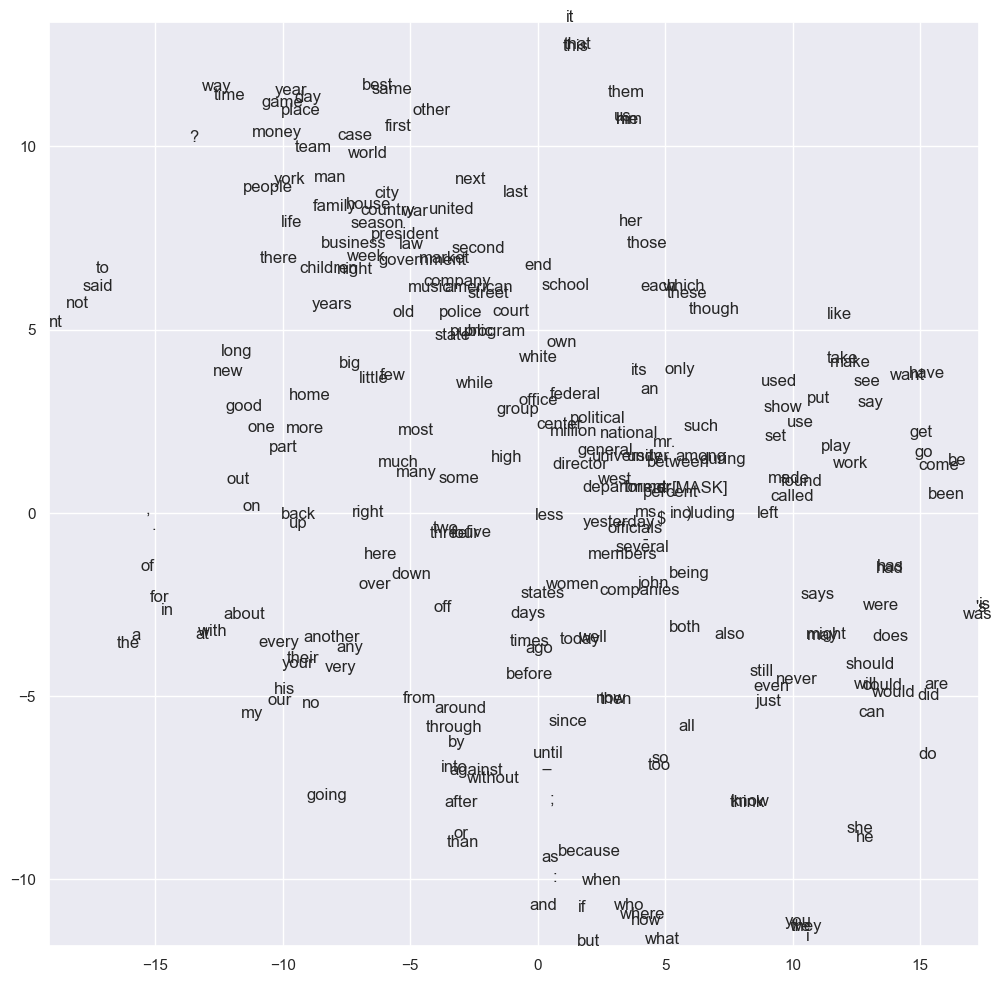

In [103]:
tsne_plot_representation(trained_model)

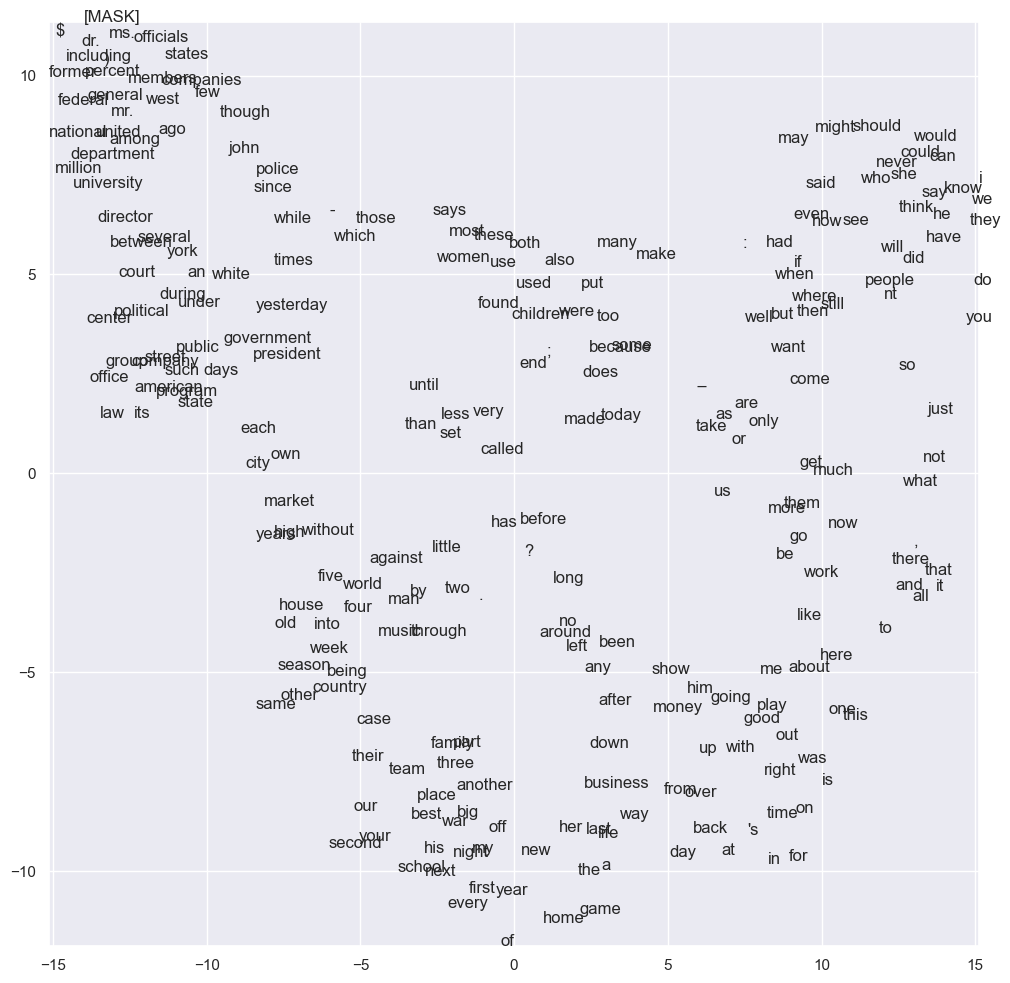

In [104]:
tsne_plot_GLoVE_representation(W_final_2d, b_final_2d)

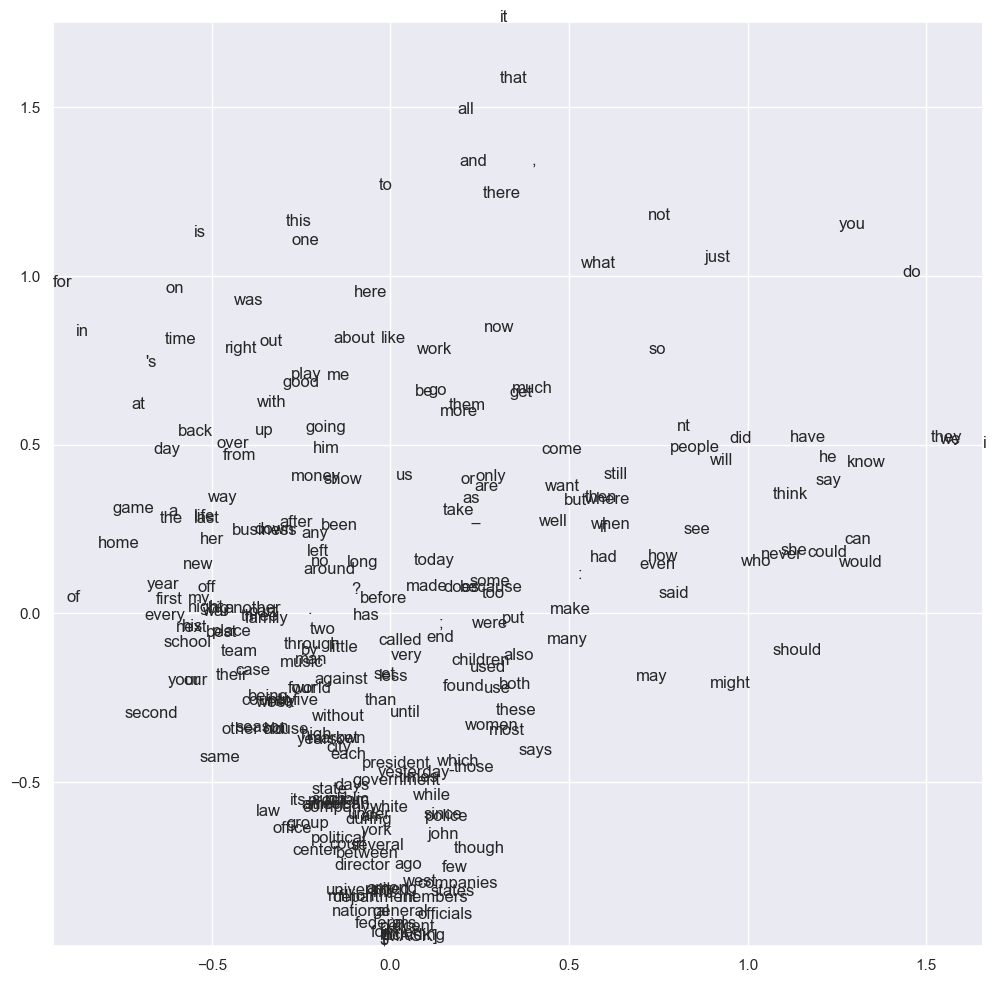

In [105]:
plot_2d_GLoVE_representation(W_final_2d, b_final_2d)

# What you have to submit

For reference, here is everything you need to hand in. See the top of this handout for submission
directions.



*   Please make sure you finish the solve problems and submit your answers and codes according to the submission instruction:
  * [ ] **Part 1**: Questions 1.1, 1.2, 1.3, 1.4. Completed code for `grad_GLoVE` function.
  * [ ] **Part 2**: Completed code for `compute_loss_derivative()` (2.1), `back_propagate()` (2.2) functions, and the output of `print_gradients()` (2.3) and (2.4)
  * [ ] **Part 3**: Questions 3.1

